In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer

# Crear registros cuánticos y clásicos
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

# Crear circuito cuántico
circuit = QuantumCircuit(q, c)

# Preparar el estado a teleportar (qubit de Alice)
circuit.h(q[0])  # Aplicar Hadamard para crear superposición
circuit.z(q[0])  # Aplicar puerta Z para cambiar la fase

# Crear entrelazamiento entre el segundo qubit de Alice y el qubit de Bob
circuit.h(q[1])
circuit.cx(q[1], q[2])

# Teleportación
circuit.cx(q[0], q[1])
circuit.h(q[0])

# Medir los qubits de Alice
circuit.measure(q[0], c[0])
circuit.measure(q[1], c[1])

# Operaciones condicionales en el qubit de Bob
circuit.x(q[2]).c_if(c, 1)  # Aplicar X si el resultado es 01
circuit.z(q[2]).c_if(c, 2)  # Aplicar Z si el resultado es 10
circuit.x(q[2]).c_if(c, 3)  # Aplicar X y Z si el resultado es 11

# Dibujar el circuito
circuit_drawer(circuit, output='mpl', filename='teleportation_circuit.png')

print(circuit)

     ┌───┐┌───┐     ┌───┐┌─┐                     
q_0: ┤ H ├┤ Z ├──■──┤ H ├┤M├─────────────────────
     ├───┤└───┘┌─┴─┐└┬─┬┘└╥┘                     
q_1: ┤ H ├──■──┤ X ├─┤M├──╫──────────────────────
     └───┘┌─┴─┐└───┘ └╥┘  ║  ┌───┐  ┌───┐  ┌───┐ 
q_2: ─────┤ X ├───────╫───╫──┤ X ├──┤ Z ├──┤ X ├─
          └───┘       ║   ║  └─╥─┘  └─╥─┘  └─╥─┘ 
                      ║   ║ ┌──╨──┐┌──╨──┐┌──╨──┐
c: 2/═════════════════╩═══╩═╡ 0x1 ╞╡ 0x2 ╞╡ 0x3 ╞
                      1   0 └─────┘└─────┘└─────┘


Resultados de la medición:
{'001': 73, '011': 166, '111': 80, '100': 80, '101': 165, '110': 168, '010': 89, '000': 179}
Estado inicial (probabilidades |0⟩, |1⟩):
|0⟩: 0.6812, |1⟩: 0.3188
Estado final aproximado de Bob (probabilidades |0⟩, |1⟩):
|0⟩: 0.6812, |1⟩: 0.3188
Fidelidad entre el estado inicial y final: 1.0000


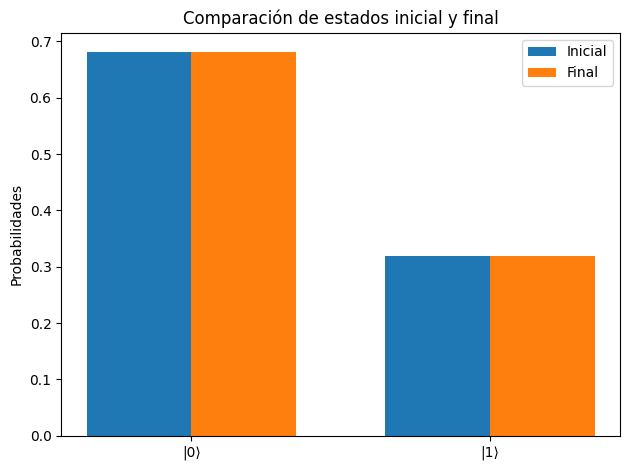

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np

# Crear registros cuánticos y clásicos
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')

# Crear circuito cuántico
qc = QuantumCircuit(q, c)

# Preparar el estado a teleportar (qubit de Alice)
qc.ry(1.2, q[0])
qc.rz(0.6, q[0])

# Crear entrelazamiento entre el segundo qubit de Alice y el qubit de Bob
qc.h(q[1])
qc.cx(q[1], q[2])

# Teleportación
qc.cx(q[0], q[1])
qc.h(q[0])

# Medir los qubits de Alice
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

# Operaciones condicionales en el qubit de Bob
qc.x(q[2]).c_if(c[0], 1)
qc.z(q[2]).c_if(c[1], 1)

# Medir el qubit de Bob
qc.measure(q[2], c[2])

# Configurar el simulador
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)

# Ejecutar el circuito
job = simulator.run(transpiled_qc, shots=1000)
result = job.result()
counts = result.get_counts()

print("Resultados de la medición:")
print(counts)
plot_histogram(counts)
plt.show()

# Función para calcular las probabilidades de |0⟩ y |1⟩
def get_probabilities(circuit):
    sv = Statevector.from_instruction(circuit)
    probs = sv.probabilities([0])
    return probs[0], probs[1]

# Estado inicial
initial_qc = QuantumCircuit(1)
initial_qc.ry(1.2, 0)
initial_qc.rz(0.6, 0)
initial_probs = get_probabilities(initial_qc)

print("Estado inicial (probabilidades |0⟩, |1⟩):")
print(f"|0⟩: {initial_probs[0]:.4f}, |1⟩: {initial_probs[1]:.4f}")

# Estado final (aproximado basado en las mediciones)
final_qc = QuantumCircuit(1)
# Aplicamos las operaciones más probables basadas en los resultados
most_common_result = max(counts, key=counts.get)
if most_common_result[0] == '1':
    final_qc.x(0)
if most_common_result[1] == '1':
    final_qc.z(0)
final_qc.ry(1.2, 0)
final_qc.rz(0.6, 0)
final_probs = get_probabilities(final_qc)

print("Estado final aproximado de Bob (probabilidades |0⟩, |1⟩):")
print(f"|0⟩: {final_probs[0]:.4f}, |1⟩: {final_probs[1]:.4f}")

# Fidelidad entre estados inicial y final
initial_sv = Statevector.from_instruction(initial_qc)
final_sv = Statevector.from_instruction(final_qc)
fidelity = np.abs(initial_sv.inner(final_sv))**2
print(f"Fidelidad entre el estado inicial y final: {fidelity:.4f}")

# Visualización simple de las probabilidades
labels = ['|0⟩', '|1⟩']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, initial_probs, width, label='Inicial')
rects2 = ax.bar(x + width/2, final_probs, width, label='Final')

ax.set_ylabel('Probabilidades')
ax.set_title('Comparación de estados inicial y final')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

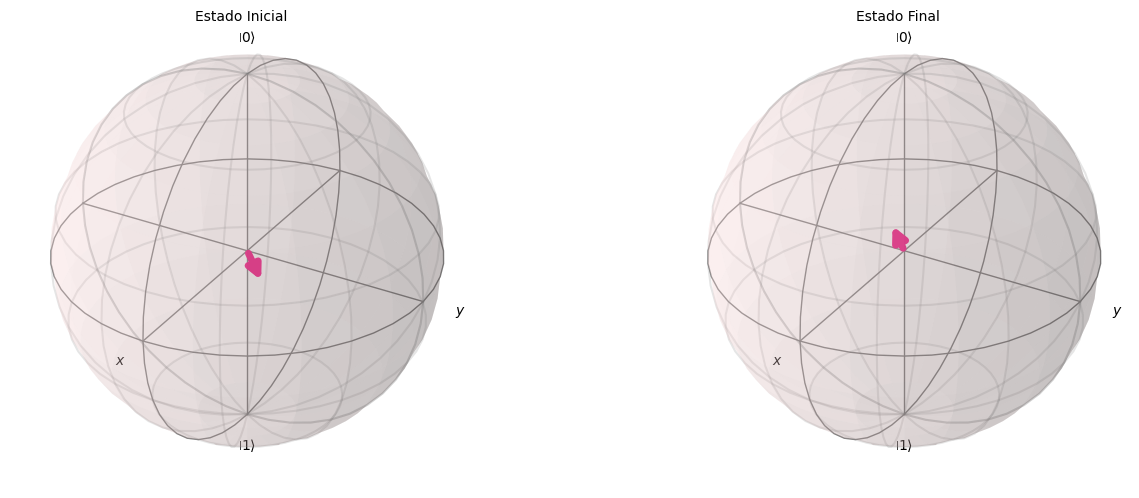

Vector de Bloch Inicial: [np.float64(0.7692450521366152), np.float64(0.5262688548013826), np.float64(0.36235775447667357)]
Vector de Bloch Final: [np.float64(-0.7692450521366152), np.float64(-0.5262688548013826), np.float64(-0.36235775447667357)]


In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# Función para obtener el vector de Bloch
def get_bloch_vector(circuit):
    state = Statevector.from_instruction(circuit)
    x = 2 * np.real(np.conj(state[0]) * state[1])
    y = 2 * np.imag(np.conj(state[0]) * state[1])
    z = np.real(np.conj(state[0]) * state[0] - np.conj(state[1]) * state[1])
    return [x, y, z]

# Crear el estado inicial
initial_circuit = QuantumCircuit(1)
initial_circuit.ry(1.2, 0)  # Rotación alrededor del eje Y
initial_circuit.rz(0.6, 0)  # Rotación alrededor del eje Z

# Obtener el vector de Bloch inicial
initial_bloch = get_bloch_vector(initial_circuit)

# Crear el circuito de teleportación
teleportation_circuit = QuantumCircuit(3, 2)
teleportation_circuit.ry(1.2, 0)  # Preparar el estado a teleportar
teleportation_circuit.rz(0.6, 0)

# Crear entrelazamiento
teleportation_circuit.h(1)
teleportation_circuit.cx(1, 2)

# Operaciones de teleportación
teleportation_circuit.cx(0, 1)
teleportation_circuit.h(0)

# Medir los qubits de Alice
teleportation_circuit.measure([0, 1], [0, 1])

# Operaciones condicionales en el qubit de Bob
teleportation_circuit.x(2).c_if(0, 1)
teleportation_circuit.z(2).c_if(1, 1)

# Configurar el simulador
simulator = AerSimulator()
transpiled_circuit = transpile(teleportation_circuit, simulator)

# Ejecutar el circuito
job = simulator.run(transpiled_circuit, shots=1)
result = job.result()
counts = result.get_counts()

# Reconstruir el estado final
final_circuit = QuantumCircuit(1)
measured_bits = list(counts.keys())[0]  # Obtenemos el único resultado
if measured_bits[0] == '1':
    final_circuit.z(0)  # Cambiamos x por z
if measured_bits[1] == '1':
    final_circuit.x(0)  # Cambiamos z por x

# Aplicamos las rotaciones originales
final_circuit.ry(1.2, 0)
final_circuit.rz(0.6, 0)

# Aplicamos las rotaciones originales
final_circuit.ry(1.2, 0)
final_circuit.rz(0.6, 0)

# Obtener el vector de Bloch final
final_bloch = get_bloch_vector(final_circuit)

# Visualizar los estados en la esfera de Bloch
fig = plt.figure(figsize=(15, 6))  # Aumentamos el ancho de la figura
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_bloch_vector(initial_bloch, title="Estado Inicial", ax=ax1)
plot_bloch_vector(final_bloch, title="Estado Final", ax=ax2)

# Ajustamos manualmente el espacio entre subplots
plt.subplots_adjust(wspace=0.3)

plt.show()

print("Vector de Bloch Inicial:", initial_bloch)
print("Vector de Bloch Final:", final_bloch)

AttributeError: 'NoneType' object has no attribute 'get_extents'

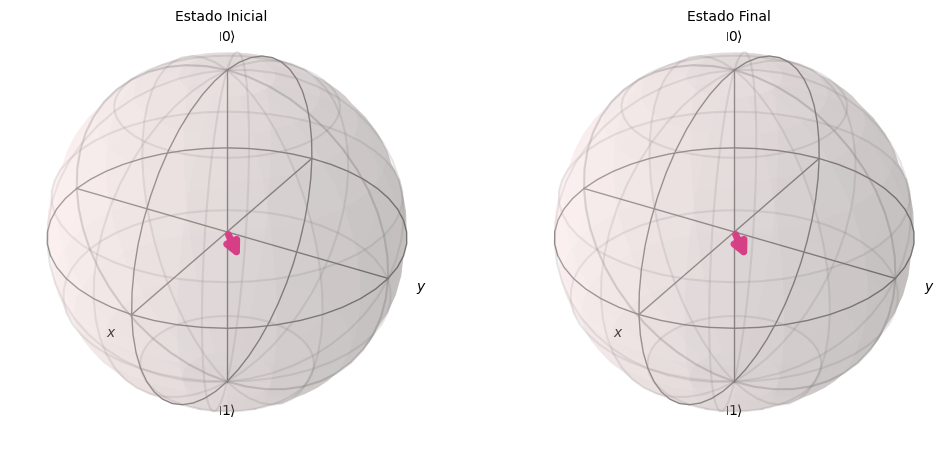

In [10]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# Función para obtener el vector de Bloch
def get_bloch_vector(circuit):
    state = Statevector.from_instruction(circuit)
    x = 2 * np.real(np.conj(state[0]) * state[1])
    y = 2 * np.imag(np.conj(state[0]) * state[1])
    z = np.real(np.conj(state[0]) * state[0] - np.conj(state[1]) * state[1])
    return [x, y, z]

# Crear el estado inicial
initial_circuit = QuantumCircuit(1)
initial_circuit.ry(1.2, 0)  # Rotación alrededor del eje Y
initial_circuit.rz(0.6, 0)  # Rotación alrededor del eje Z

# Obtener el vector de Bloch inicial
initial_bloch = get_bloch_vector(initial_circuit)

# Crear el circuito de teleportación
teleportation_circuit = QuantumCircuit(3, 2)
teleportation_circuit.ry(1.2, 0)  # Preparar el estado a teleportar
teleportation_circuit.rz(0.6, 0)

# Crear entrelazamiento
teleportation_circuit.h(1)
teleportation_circuit.cx(1, 2)

# Operaciones de teleportación
teleportation_circuit.cx(0, 1)
teleportation_circuit.h(0)

# Medir los qubits de Alice
teleportation_circuit.measure([0, 1], [0, 1])

# Operaciones condicionales en el qubit de Bob
teleportation_circuit.x(2).c_if(0, 1)
teleportation_circuit.z(2).c_if(1, 1)

# Configurar el simulador
simulator = AerSimulator()
transpiled_circuit = transpile(teleportation_circuit, simulator)

# Ejecutar el circuito
job = simulator.run(transpiled_circuit, shots=1)
result = job.result()
counts = result.get_counts()

# Reconstruir el estado final
final_circuit = QuantumCircuit(1)
measured_bits = list(counts.keys())[0]  # Obtenemos el único resultado
if measured_bits[0] == '1':
    final_circuit.x(0)
if measured_bits[1] == '1':
    final_circuit.z(0)

final_circuit.ry(1.2, 0)
final_circuit.rz(0.6, 0)

# Obtener el vector de Bloch final
final_bloch = get_bloch_vector(final_circuit)

# Visualizar los estados en la esfera de Bloch
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_bloch_vector(initial_bloch, title="Estado Inicial", ax=ax1)
plot_bloch_vector(final_bloch, title="Estado Final", ax=ax2)

plt.tight_layout()
plt.show()

print("Vector de Bloch Inicial:", initial_bloch)
print("Vector de Bloch Final:", final_bloch)

Vector de Bloch Inicial: [np.float64(0.7692450521366152), np.float64(0.5262688548013826), np.float64(0.36235775447667357)]
Resultados de la medición: {'00': 249, '10': 264, '11': 253, '01': 234}
Resultado más común: 10
Vector de Bloch Final (antes de rotaciones): [np.float64(0.0), np.float64(0.0), np.float64(1.0)]
Vector de Bloch Final (después de rotaciones): [np.float64(0.7692450521366152), np.float64(0.5262688548013826), np.float64(0.36235775447667357)]


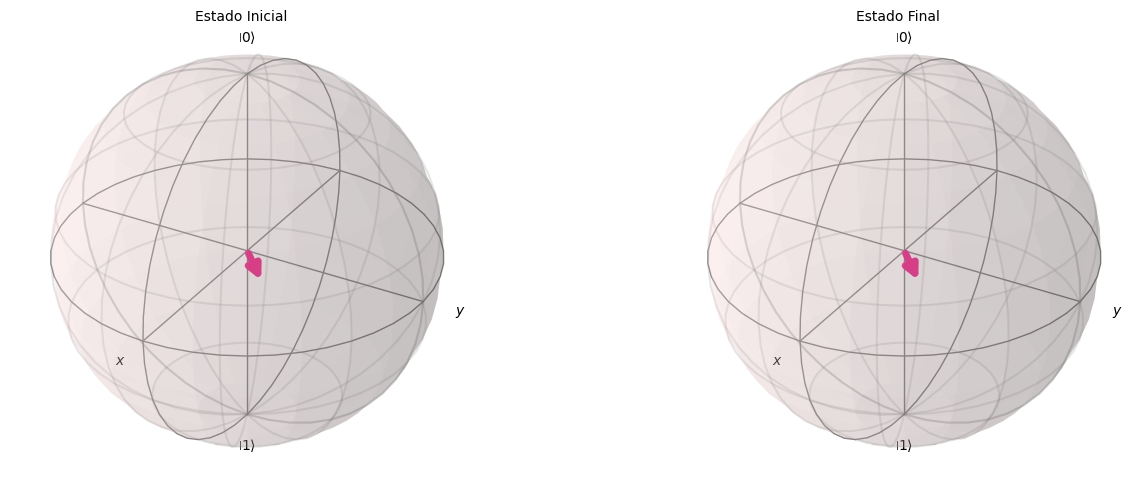

In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

def get_bloch_vector(circuit):
    state = Statevector.from_instruction(circuit)
    x = 2 * np.real(np.conj(state.data[0]) * state.data[1])
    y = 2 * np.imag(np.conj(state.data[0]) * state.data[1])
    z = np.real(np.conj(state.data[0]) * state.data[0] - np.conj(state.data[1]) * state.data[1])
    return [x, y, z]

# Crear el estado inicial
initial_circuit = QuantumCircuit(1)
initial_circuit.ry(1.2, 0)
initial_circuit.rz(0.6, 0)

initial_bloch = get_bloch_vector(initial_circuit)
print("Vector de Bloch Inicial:", initial_bloch)

# Crear el circuito de teleportación
qc = QuantumCircuit(3, 2)

# Preparar el estado a teleportar
qc.ry(1.2, 0)
qc.rz(0.6, 0)

# Crear entrelazamiento
qc.h(1)
qc.cx(1, 2)

# Operaciones de teleportación
qc.cx(0, 1)
qc.h(0)

# Medir los qubits de Alice
qc.measure([0, 1], [0, 1])

# Operaciones condicionales en el qubit de Bob
qc.z(2).c_if(0, 1)
qc.x(2).c_if(1, 1)

# Configurar el simulador
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)

# Ejecutar el circuito
job = simulator.run(transpiled_qc, shots=1000)
result = job.result()
counts = result.get_counts()
print("Resultados de la medición:", counts)

# Reconstruir el estado final
most_common_result = max(counts, key=counts.get)
print("Resultado más común:", most_common_result)

final_circuit = QuantumCircuit(1)
if most_common_result[0] == '1':
    final_circuit.z(0)
if most_common_result[1] == '1':
    final_circuit.x(0)

final_bloch = get_bloch_vector(final_circuit)
print("Vector de Bloch Final (antes de rotaciones):", final_bloch)

# Aplicar rotaciones al estado final
final_circuit.ry(1.2, 0)
final_circuit.rz(0.6, 0)

final_bloch_rotated = get_bloch_vector(final_circuit)
print("Vector de Bloch Final (después de rotaciones):", final_bloch_rotated)

# Visualizar los estados en la esfera de Bloch
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_bloch_vector(initial_bloch, title="Estado Inicial", ax=ax1)
plot_bloch_vector(final_bloch_rotated, title="Estado Final", ax=ax2)

plt.subplots_adjust(wspace=0.3)
plt.show()